# Image Classification using flowers data set providing by Google.
## Importing the libraries that we are going to use.

In [0]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Downloading the dataset

In [0]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="flower_photos.tgz", 
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

## Exploring our dataset

In [0]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))
  train, val = images[:num_train], images[num_train:]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))
    
round(len(images)*0.8)

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


# Data Augmentation

Overfitting generally occurs when we have small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.


In [0]:
batch_size = 200
IMG_SHAPE = 256

image_gen_train = ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=45,
                    width_shift_range=.25, 
                    height_shift_range=.25, 
                    horizontal_flip=True,
                    vertical_flip=True,
                    zoom_range=0.3,                
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size, 
                                                directory=train_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

Found 2935 images belonging to 5 classes.


Let's preview the changes that we made in a random picture from our dataset.

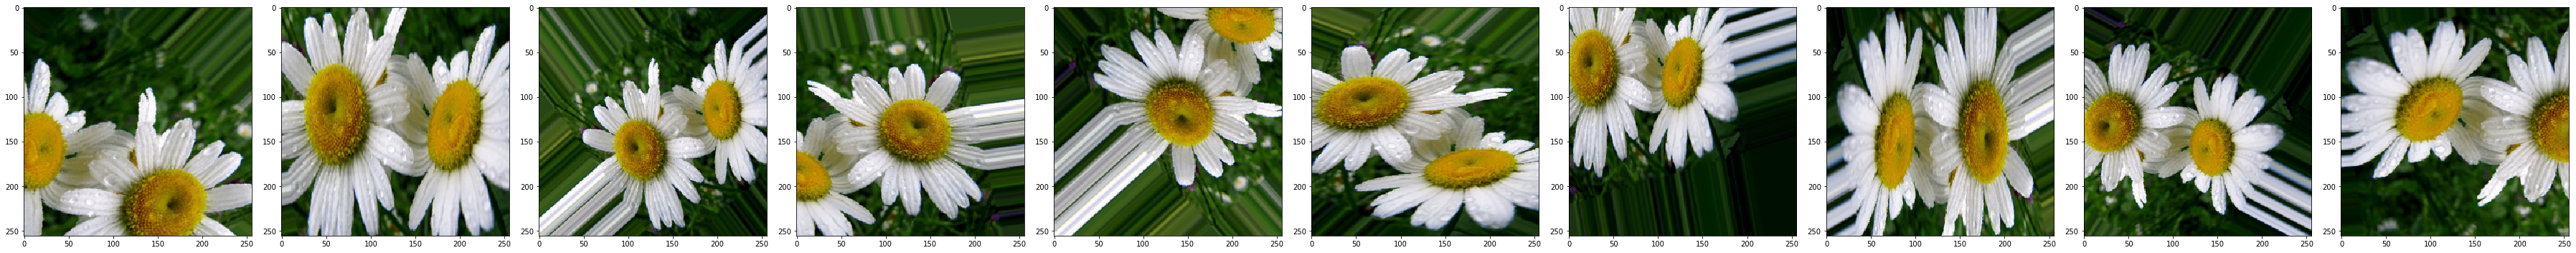

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(50,50))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(10)]
plotImages(augmented_images)

Now let's create our validation data set. Note that in the validation data set we will not use data augmentantion as we want to test the accuracy of our model in real data.

In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size, 
                                                 directory=val_dir, 
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 735 images belonging to 5 classes.


## Setting up the network's architecture

In [0]:
model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3))) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

And compiling our model.

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


## Training the CNN.
We will randomly choose to train our model in 80 epochs. This will give us a clear view in order to know if we need more epochs or less depedning on the loss function that we will compare after the completion of training of our model.

In [0]:
epochs = 80

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))),
    verbose=1
)

Epoch 1/80
15/15 [==============================] - 45s 3s/step - loss: 3.1867 - acc: 0.2320 - val_loss: 1.5474 - val_acc: 0.2571
Epoch 2/80
15/15 [==============================] - 42s 3s/step - loss: 1.4426 - acc: 0.3751 - val_loss: 1.2862 - val_acc: 0.4463
Epoch 3/80
15/15 [==============================] - 42s 3s/step - loss: 1.2264 - acc: 0.4753 - val_loss: 1.2160 - val_acc: 0.5088
Epoch 4/80
15/15 [==============================] - 42s 3s/step - loss: 1.1530 - acc: 0.5336 - val_loss: 1.1213 - val_acc: 0.5537
Epoch 5/80
15/15 [==============================] - 42s 3s/step - loss: 1.1171 - acc: 0.5523 - val_loss: 1.1294 - val_acc: 0.5850
Epoch 6/80
15/15 [==============================] - 42s 3s/step - loss: 1.0611 - acc: 0.5796 - val_loss: 1.0045 - val_acc: 0.5973
Epoch 7/80
15/15 [==============================] - 42s 3s/step - loss: 1.0184 - acc: 0.5911 - val_loss: 0.9866 - val_acc: 0.6095
Epoch 8/80
15/15 [==============================] - 42s 3s/step - loss: 1.0074 - acc: 0.60

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



NameError: ignored